<a href="https://colab.research.google.com/github/anuraagbhavaraju/computer-vision-chest-xray/blob/full_notebook/CXR_Classification_Comparitive_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Data from Kaggle

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d raddar/tuberculosis-chest-xrays-montgomery

 99% 581M/585M [00:08<00:00, 37.5MB/s]
100% 585M/585M [00:08<00:00, 73.3MB/s]


In [ ]:
!unzip /content/tuberculosis-chest-xrays-montgomery.zip

In [7]:
!kaggle datasets download -d raddar/tuberculosis-chest-xrays-shenzhen

100% 3.49G/3.51G [00:57<00:00, 86.6MB/s]
100% 3.51G/3.51G [00:57<00:00, 65.6MB/s]


In [ ]:
!unzip /content/tuberculosis-chest-xrays-shenzhen.zip

In [9]:
# !kaggle datasets download -d raddar/nodules-in-chest-xrays-jsrt

In [10]:
# !unzip /content/nodules-in-chest-xrays-jsrt.zip

In [11]:
!kaggle datasets download -d hmchuong/xray-bone-shadow-supression

100% 5.21G/5.23G [01:05<00:00, 74.2MB/s]
100% 5.23G/5.23G [01:05<00:00, 86.1MB/s]


In [ ]:
!unzip /content/xray-bone-shadow-supression.zip

In [13]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:15<00:00, 194MB/s]
100% 2.29G/2.29G [00:15<00:00, 156MB/s]


In [ ]:
!unzip /content/chest-xray-pneumonia

# Meta Data Pre-Processing

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

montgomery_df = pd.read_csv('/content/montgomery_metadata.csv')
montgomery_df['datasource']='montgomery_df'
shenzhen_df = pd.read_csv('/content/shenzhen_metadata.csv')
shenzhen_df['datasource']='shenzhen_df'
jsrt_df = pd.read_csv('/content/jsrt_metadata.csv')
jsrt_df['datasource']='jsrt_df'
shenzhen_df=shenzhen_df.rename(columns={'sex':'gender'})
all_xray_df = montgomery_df.append(shenzhen_df)
all_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('..', 'content', 'images*', '*', '*.png'))}
jsrt_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('..', 'content', 'JSRT*', '*', '*.png'))}
bse_jsrt_image_paths = {os.path.basename(x): x for x in
                   glob(os.path.join('..', 'content', 'BSE_JSRT*', '*', '*.png'))}
all_xray_df['path']=all_xray_df['study_id'].apply(lambda x:all_image_paths.get(x))
jsrt_df['path']=jsrt_df['study_id'].apply(lambda x:jsrt_image_paths.get(x))
jsrt_df['bse_path']=jsrt_df['study_id'].apply(lambda x:bse_jsrt_image_paths.get(x))
all_xray_df=all_xray_df[all_xray_df['path'].notna()]
jsrt_df=jsrt_df[(jsrt_df['path'].notna()) & (jsrt_df['bse_path'].notna())]
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df.sample(3)

Scans found: 800 , Total Headers 800


<ipython-input-1-39fd4125cd4c>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_xray_df = montgomery_df.append(shenzhen_df)


,study_id,age,gender,findings,datasource,path
59,MCUCXR_0080_0.png,5,O,normal,montgomery_df,../content/images/transformed_images/MCUCXR_00...
442,CHNCXR_0443_1.png,36,Male,right upper PTB,shenzhen_df,../content/images/transformed_images/CHNCXR_04...
144,CHNCXR_0145_0.png,45,Male,normal,shenzhen_df,../content/images/transformed_images/CHNCXR_01...


In [2]:
from pathlib import Path
# Define path to the data directory
data_dir = Path('/content/chest_xray')
# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'
# Path to validation directory
val_dir = data_dir / 'val'
# Path to test directory
test_dir = data_dir / 'test'
########################################################################################
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'
# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []
# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    train_data.append((img,0))
# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    train_data.append((img, 1))
# Get a pandas dataframe from the data we have in our list
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)
# Shuffle the data
train_data = train_data.sample(frac=1.).reset_index(drop=True)
########################################################################################
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'
# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
# An empty list. We will insert the data into this list in (img_path, label) format
valid_data = []
# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    valid_data.append((img,0))
# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    valid_data.append((img, 1))
# Get a pandas dataframe from the data we have in our list
valid_data = pd.DataFrame(valid_data, columns=['image', 'label'],index=None)
# Shuffle the data
valid_data = valid_data.sample(frac=1.).reset_index(drop=True)
########################################################################################
# Get the path to the normal and pneumonia sub-directories
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'
# Get the list of all the images
normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []
# Go through all the normal cases. The label for these cases will be 0
for img in normal_cases:
    test_data.append((img,0))
# Go through all the pneumonia cases. The label for these cases will be 1
for img in pneumonia_cases:
    test_data.append((img, 1))
# Get a pandas dataframe from the data we have in our list
test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)
# Shuffle the data
test_data = test_data.sample(frac=1.).reset_index(drop=True)
train_data=train_data.append(valid_data)
train_data=train_data.append(test_data)

<ipython-input-2-a6c1b21a8b51>:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data=train_data.append(valid_data)
<ipython-input-2-a6c1b21a8b51>:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_data=train_data.append(test_data)


In [3]:
train_data=train_data.rename(columns={'image':'path','label':'findings'})
train_data['findings']=np.where(train_data['findings']==1,'abnormal','normal')
train_data['path']=train_data['path'].astype(str)
train_data['datasource']='train_data'

In [4]:
# For training CLAHE Transformed images
all_xray_df['path']=all_xray_df['path'].apply(lambda x:x.replace('/content/images/images/','content/images/transformed_images/'))
train_data['path']=train_data['path'].apply(lambda x:x.replace('/content/chest_xray/train/PNEUMONIA/','/content/chest_xray/CLAHE_Transformed/'))
train_data['path']=train_data['path'].apply(lambda x:x.replace('/content/chest_xray/train/NORMAL/','/content/chest_xray/CLAHE_Transformed/'))
train_data['path']=train_data['path'].apply(lambda x:x.replace('/content/chest_xray/test/PNEUMONIA/','/content/chest_xray/CLAHE_Transformed/'))
train_data['path']=train_data['path'].apply(lambda x:x.replace('/content/chest_xray/test/NORMAL/','/content/chest_xray/CLAHE_Transformed/'))
train_data=train_data[train_data['path'].notna()]

In [5]:
# # For training BLACKHAT_Transformed images
# all_xray_df['path']=all_xray_df['path'].apply(lambda x:x.replace('/content/images/images/','content/images/transformed_images_blackhat/'))
# train_data['path']=train_data['path'].apply(lambda x:x.replace('/content/chest_xray/train/PNEUMONIA/','/content/chest_xray/BLACKHAT_Transformed/'))
# train_data['path']=train_data['path'].apply(lambda x:x.replace('/content/chest_xray/train/NORMAL/','/content/chest_xray/BLACKHAT_Transformed/'))
# train_data['path']=train_data['path'].apply(lambda x:x.replace('/content/chest_xray/test/PNEUMONIA/','/content/chest_xray/BLACKHAT_Transformed/'))
# train_data['path']=train_data['path'].apply(lambda x:x.replace('/content/chest_xray/test/NORMAL/','/content/chest_xray/BLACKHAT_Transformed/'))
# train_data=train_data[train_data['path'].notna()]

In [6]:
all_xray_df=all_xray_df.append(train_data)

<ipython-input-6-0742edc2fb46>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_xray_df=all_xray_df.append(train_data)


In [7]:
# all_xray_df['path']=np.where(all_xray_df['datasource']=='train_data','/content/chest_xray/CLAHE_Transformed',all_xray_df['path'])

In [8]:
all_xray_df['datasource'].value_counts()

train_data       5856
shenzhen_df       662
montgomery_df     138
Name: datasource, dtype: int64

# Data Pre-Processing

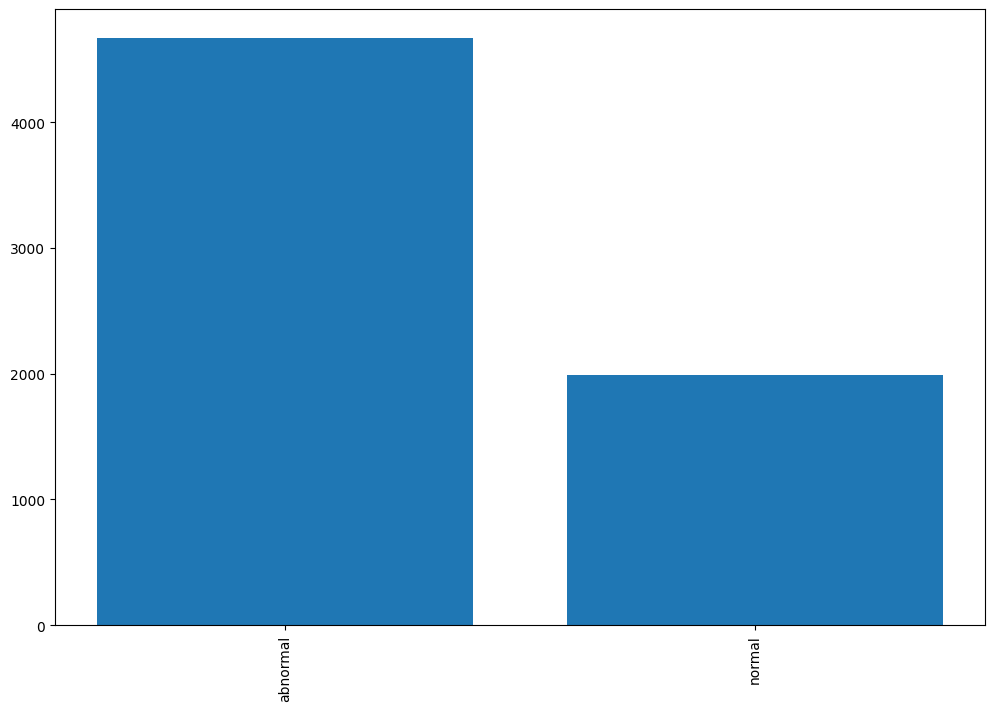

In [9]:
all_xray_df['findings']=np.where(all_xray_df['findings']!='normal','abnormal','normal')
jsrt_df=jsrt_df[['study_id','age','gender','diagnosis','path','bse_path']]
jsrt_df=jsrt_df.rename(columns={'diagnosis':'findings'})
jsrt_df['findings']=jsrt_df['findings'].fillna('normal')
jsrt_df['findings']=np.where(jsrt_df['findings']!='normal','abnormal','normal')
label_counts = all_xray_df['findings'].value_counts()
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [10]:
all_labels = np.unique(list(all_xray_df['findings']))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
all_xray_df.sample(3)

All Labels (2): ['abnormal', 'normal']


,study_id,age,gender,findings,datasource,path
467,NaN,NaN,NaN,normal,train_data,/content/chest_xray/CLAHE_Transformed/NORMAL2-...
3947,NaN,NaN,NaN,normal,train_data,/content/chest_xray/CLAHE_Transformed/NORMAL2-...
1993,NaN,NaN,NaN,abnormal,train_data,/content/chest_xray/CLAHE_Transformed/person12...


# Image Processing

In [58]:
# Create content/images/transformed_images folder before running this cell
import cv2
directory='/content/images/images/'
new_directory='/content/images/transformed_images/'
for img in os.listdir(directory):
  filename =directory+img # path to the image file
  image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
  img_clahe = clahe.apply(image)
  # #plt.imshow(img_clahe,cmap='gray')
  try:
    cv2.imwrite(new_directory+img,img_clahe)
  except:
    print("couldn't convert ",img)

couldn't convert  Untitled Folder


In [59]:
# # Create content/images/transformed_images_blackhat folder before running this cell
# import cv2
# directory='/content/images/transformed_images/'
# new_directory='/content/images/transformed_images_blackhat/'
# for img in os.listdir(directory):
#   filename =directory+img # path to the image file
#   img_clahe = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
#   ker = 169
#   kernel = np.ones((ker,ker),np.uint8)
#   blackhat = cv2.morphologyEx(img_clahe, cv2.MORPH_BLACKHAT, kernel)
#   try:
#     cv2.imwrite(new_directory+img,blackhat)
#   except:
#     print("couldn't convert ",img)



In [ ]:
# Create content/chest_xray/CLAHE_Transformed folder before running this cell
import cv2
cnt=0
for main_folder in ['/content/chest_xray/chest_xray/']:
  for sel_folder in ['train/','val/','test/']:
    for class_folder in ['PNEUMONIA/','NORMAL/']:
      directory=main_folder+sel_folder+class_folder
      new_directory='/content/chest_xray/CLAHE_Transformed/'
      for img in os.listdir(directory):
        filename =directory+img # path to the image file
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_clahe = clahe.apply(image)
        cnt+=1
        if cnt%100==0:
          print(cnt,' images processed')
        # #plt.imshow(img_clahe,cmap='gray')
        #cv2.imwrite(new_directory+img,img_clahe)
        try:
          cv2.imwrite(new_directory+img,img_clahe)
        except:
          print("couldn't convert ",img)

In [67]:
# import cv2
# directory='/content/chest_xray/CLAHE_Transformed/'
# new_directory='/content/chest_xray/BLACKHAT_Transformed/'
# for img in os.listdir(directory):
#   filename =directory+img # path to the image file
#   img_clahe = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
#   ker = 169
#   kernel = np.ones((ker,ker),np.uint8)
#   blackhat = cv2.morphologyEx(img_clahe, cv2.MORPH_BLACKHAT, kernel)
#   try:
#     cv2.imwrite(new_directory+img,blackhat)
#   except:
#     print("couldn't convert ",img)



## Chest Segmentation Expiriments

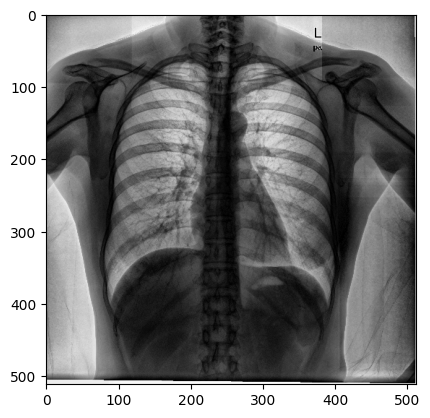

In [ ]:
import cv2
filename ='/content/images/images/CHNCXR_0003_0.png' # path to the image file
image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
image=cv2.resize(image,(512,512))
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(image)
ker = 169
kernel = np.ones((ker,ker),np.uint8)
blackhat = cv2.morphologyEx(img_clahe, cv2.MORPH_BLACKHAT, kernel)
plt.imshow(blackhat,cmap='gray')

AttributeError: ignored

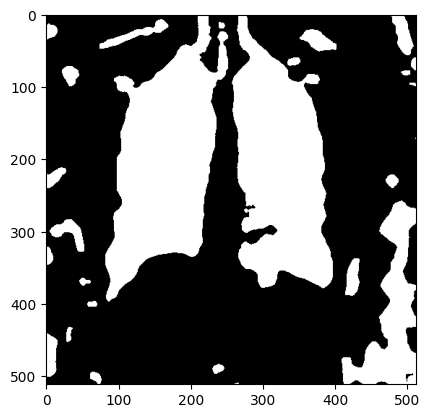

In [ ]:
import cv2
filename ='/content/images/transformed_images_blackhat/CHNCXR_0006_0.png' # path to the image file
image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
image=cv2.resize(image,(512,512))
threshold = 45
ret, thresh = cv2.threshold(blackhat, threshold, 255, 0)
plt.imshow(thresh,cmap='gray')
def get_cmask(img, maxCorners=3800, qualityLevel=0.001, minDistance=1,Cradius=6):
    corners = cv2.goodFeaturesToTrack(img, maxCorners, qualityLevel, minDistance)
    corners = np.int0(corners)
    cmask = np.zeros(img.shape)
    for corner in corners:
        x,y = corner.ravel()
        cv2.circle(cmask,(x,y),Cradius,1,-1)
    return cmask
cmask = get_cmask(img_clahe)
plt.imshow(cmask,cmap='gray')

mask = np.multiply(cmask,thresh).astype('uint8')
plt.imshow(mask,cmap='gray')

median = cv2.medianBlur(mask,23)
plt.imshow(median,cmap='gray')

def contourMask(image):
    contours,hierc = cv2.findContours(image,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    area = np.zeros(len(contours))
    for j in range(len(contours)):
        cnt = contours[j]
        area[j] = cv2.contourArea(cnt)
    mask = np.zeros(image.shape)
    cv2.drawContours(mask, contours, np.argmax(area), (255), -1)#draw largest contour-usually right lung
    temp = np.copy(area[np.argmax(area)])
    area[np.argmax(area)]=0
    if area[np.argmax(area)] > temp/10:#make sure 2nd largest contour is also lung, not 2 lungs connected
        cv2.drawContours(mask, contours, np.argmax(area), (255), -1)#draw second largest contour
    contours.clear()
    return mask

contour_mask = contourMask(median).astype('uint8')
#contour_mask=median
plt.imshow(contour_mask,cmap='gray')


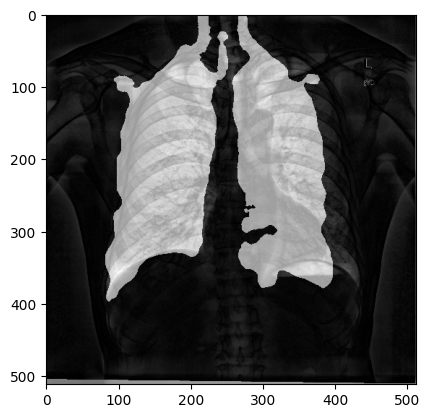

In [ ]:
blended = cv2.addWeighted(image, 0.5, contour_mask, 0.5, 0)
plt.imshow(blended,cmap='gray')

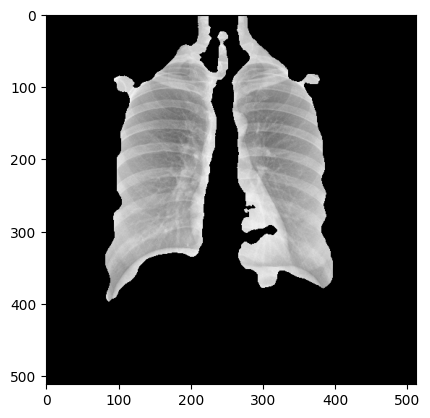

In [ ]:
bitwiseAnd = cv2.bitwise_and(image, contour_mask)
plt.imshow( bitwiseAnd,cmap='gray')

# Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df,
                                   test_size = 0.25,
                                   random_state = 2018,
                                   stratify = all_xray_df['findings'])
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 4992 validation 1664


In [12]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [13]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir,
                                     class_mode = 'categorical',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [14]:
train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
directory=None,
x_col = 'path',
y_col = 'findings',
class_mode = 'categorical',
classes = all_labels,
target_size = IMG_SIZE,
#color_mode = 'grayscale',
batch_size = 32)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
directory=None,
x_col = 'path',
y_col = 'findings',
class_mode = 'categorical',
classes = all_labels,
target_size = IMG_SIZE,
#color_mode = 'grayscale',
batch_size = 256) # we can use much larger batches for evaluation

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
directory=None,
x_col = 'path',
y_col = 'findings',
class_mode = 'categorical',
classes = all_labels,
target_size = IMG_SIZE,
#color_mode = 'grayscale',
batch_size = 1024))

Found 4992 validated image filenames belonging to 2 classes.
Found 1664 validated image filenames belonging to 2 classes.
Found 1664 validated image filenames belonging to 2 classes.


# Modelling

## Initializing CNN Architectures

### MobileNet

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
optm = Adam(lr=0.0001)
base_mobilenet_model = MobileNet(input_shape =  (128,128,3),#t_x.shape[1:],
                                 include_top = False, weights = "imagenet")
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'softmax'))
multi_disease_model.compile(optimizer = optm, loss = 'categorical_crossentropy',
                           metrics = ['accuracy', 'mae'])
multi_disease_model.summary()

17225924/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functi  (None, 4, 4, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                         

### MobileNetV2

In [15]:
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
optm = Adam(lr=0.0001)
base_mobilenet_model = MobileNetV2(input_shape =  (128,128,3),#t_x.shape[1:],
                                 include_top = False, weights = "imagenet")
multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'softmax'))
multi_disease_model.compile(optimizer = optm, loss = 'categorical_crossentropy',
                           metrics = ['accuracy', 'mae'])
multi_disease_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1

### Inception v3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
pre_trained_model = InceptionV3(input_shape = (128, 128,3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')
for layer in pre_trained_model.layers:
  layer.trainable = False
import zipfile
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = layers.Flatten()(pre_trained_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense  (2, activation='softmax')(x)

multi_disease_model = Model( pre_trained_model.input, x)

multi_disease_model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy', 'mae'])


87910968/87910968 [==============================] - 1s 0us/step


### Inception v3 - Consistent Architecture

In [ ]:
# from tensorflow.keras.applications.inception_v3 import InceptionV3
# from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
# from keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# optm = Adam(lr=0.0001)
# base_mobilenet_model = InceptionV3(input_shape = (128, 128,3), # Shape of our images
#                                 include_top = False, # Leave out the last fully connected layer
#                                 weights = 'imagenet')
# for layer in multi_disease_model.layers:
#   layer.trainable = False
# multi_disease_model = Sequential()
# multi_disease_model.add(base_mobilenet_model)
# multi_disease_model.add(GlobalAveragePooling2D())
# multi_disease_model.add(Dropout(0.5))
# multi_disease_model.add(Dense(512))
# multi_disease_model.add(Dropout(0.5))
# multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
# multi_disease_model.compile(optimizer = optm, loss = 'binary_crossentropy',
#                            metrics = ['binary_accuracy', 'mae'])
# multi_disease_model.summary()

### ResNet-50

In [ ]:
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
optm = Adam(lr=0.0001)
imported_model= tf.keras.applications.ResNet50(include_top=False,
input_shape=(128,128,3),
pooling='avg',classes=2,
weights='imagenet')
for layer in imported_model.layers:
  layer.trainable=False

multi_disease_model = Sequential()
multi_disease_model.add(imported_model)
multi_disease_model.add(Flatten())
multi_disease_model.add(Dense(512, activation='relu'))
#multi_disease_model.add(Dense(512))
#multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'softmax'))
multi_disease_model.compile(optimizer = optm, loss = 'categorical_crossentropy',
                           metrics = ['accuracy', 'mae'])
multi_disease_model.summary()


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_9 (ModuleWr  (None, 2048)              0         
 apper)                                                          
                                                                 
 module_wrapper_10 (ModuleW  (None, 512)               1049088   
 rapper)                                                         
                                                                 
 module_wrapper_11 (ModuleW  (None, 2)                 1026      
 rapper)                                                         
                                                                 
Total params: 24637826 (93.99 MB)
Trainable params: 1050114 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
________

### VGG-16 Model

In [ ]:
input_shape = (128, 128, 3)
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
model_input = Input(shape=input_shape)
from tensorflow.keras.optimizers import Adam
optm = Adam(lr=0.0001)
from keras.applications.vgg16 import VGG16
vgg16_cnn = VGG16(include_top=False, weights='imagenet',
                        input_tensor=model_input)
vgg16_cnn.summary()
base_model_vgg16=Model(inputs=vgg16_cnn.input,
                        outputs=vgg16_cnn.get_layer('block5_conv3').output)
x = base_model_vgg16.output
# x = Flatten(name="flatten")(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
# x = Dense(512,activation='relu')(x)
# x = Dropout(0.5)(x)
predictions = Dense(2,
                    activation='softmax', name='predictions')(x)
multi_disease_model = Model(inputs=base_model_vgg16.input,
                    outputs=predictions,
                    name = 'vgg16_cxrpretrained')
multi_disease_model.compile(optimizer = optm, loss = 'categorical_crossentropy',
                           metrics = ['accuracy', 'mae'])
multi_disease_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

## Fitting Model

In [16]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight("balanced", classes=np.unique(train_gen.classes), y=train_gen.classes)
cw = dict(zip( np.unique(train_gen.classes), weights))
print(cw)

{0: 0.7131428571428572, 1: 1.6729222520107239}


In [17]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)
callbacks_list = [checkpoint, early]

In [18]:
history=multi_disease_model.fit(train_gen,
                                  steps_per_epoch=156,
                                  validation_data = (test_X, test_Y),
                                  epochs = 32,
                                class_weight=cw,
                                  callbacks = callbacks_list)

Epoch 1/32
156/156 [==============================] - ETA: 0s - loss: 0.5062 - accuracy: 0.8526 - mae: 0.1725
Epoch 1: val_loss improved from inf to 2.85073, saving model to xray_class_weights.best.hdf5
156/156 [==============================] - 456s 3s/step - loss: 0.5062 - accuracy: 0.8526 - mae: 0.1725 - val_loss: 2.8507 - val_accuracy: 0.8242 - val_mae: 0.1749
Epoch 2/32
156/156 [==============================] - ETA: 0s - loss: 0.2284 - accuracy: 0.9012 - mae: 0.1330
Epoch 2: val_loss improved from 2.85073 to 1.00502, saving model to xray_class_weights.best.hdf5
156/156 [==============================] - 422s 3s/step - loss: 0.2284 - accuracy: 0.9012 - mae: 0.1330 - val_loss: 1.0050 - val_accuracy: 0.8252 - val_mae: 0.1727
Epoch 3/32
156/156 [==============================] - ETA: 0s - loss: 0.2057 - accuracy: 0.9109 - mae: 0.1205
Epoch 3: val_loss improved from 1.00502 to 0.64114, saving model to xray_class_weights.best.hdf5
156/156 [==============================] - 435s 3s/step

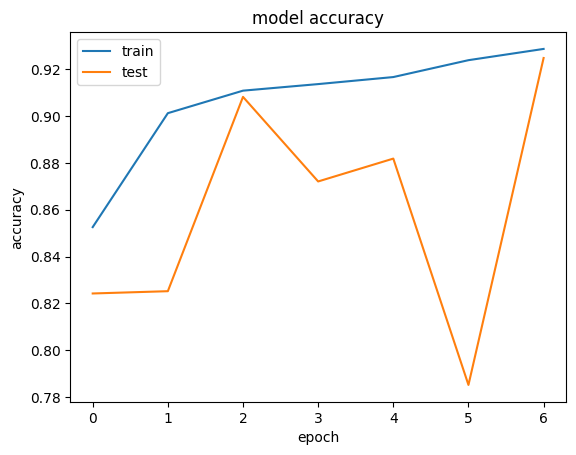

In [21]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


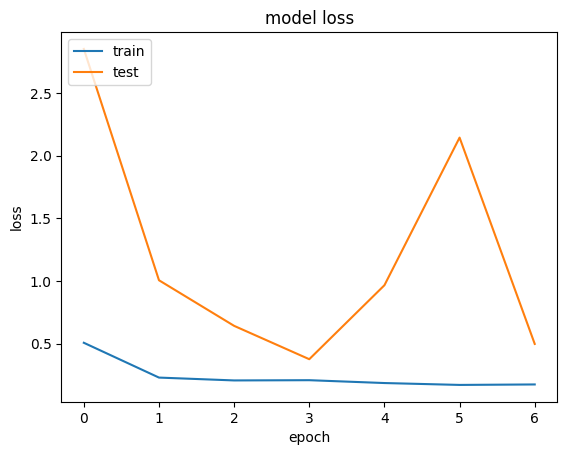

In [29]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [111]:
 multi_disease_model.save('/content/final_model')

In [ ]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

# Model Prediction

In [24]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

32/32 [==============================] - 17s 432ms/step


In [25]:
from sklearn.metrics import confusion_matrix, classification_report
# Convert predicted probabilities to class labels
pred_labels = np.argmax(pred_Y, axis=1)

# Assuming test_Y is one-hot encoded, convert it to class labels
true_labels = np.argmax(test_Y, axis=1)

# Create confusion matrix
conf_mat = confusion_matrix(true_labels, pred_labels)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_mat)

# You can also use classification_report for additional metrics
print("\nClassification Report:")
print(classification_report(true_labels, pred_labels))


Confusion Matrix:
[[673  56]
 [ 21 274]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       729
           1       0.83      0.93      0.88       295

    accuracy                           0.92      1024
   macro avg       0.90      0.93      0.91      1024
weighted avg       0.93      0.92      0.93      1024



<Axes: >

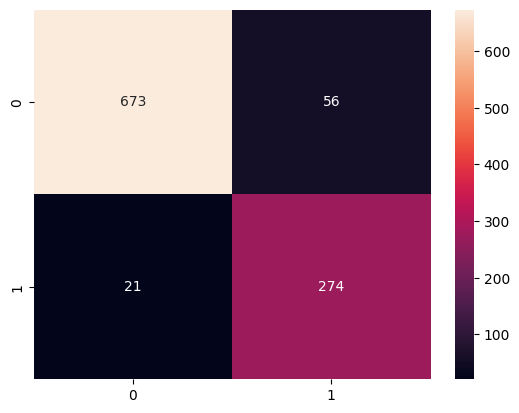

In [37]:
import seaborn as sns
sns.heatmap(conf_mat, annot=True,fmt=".3g")


# Model Evaluation

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

# Ad-Hoc Validation

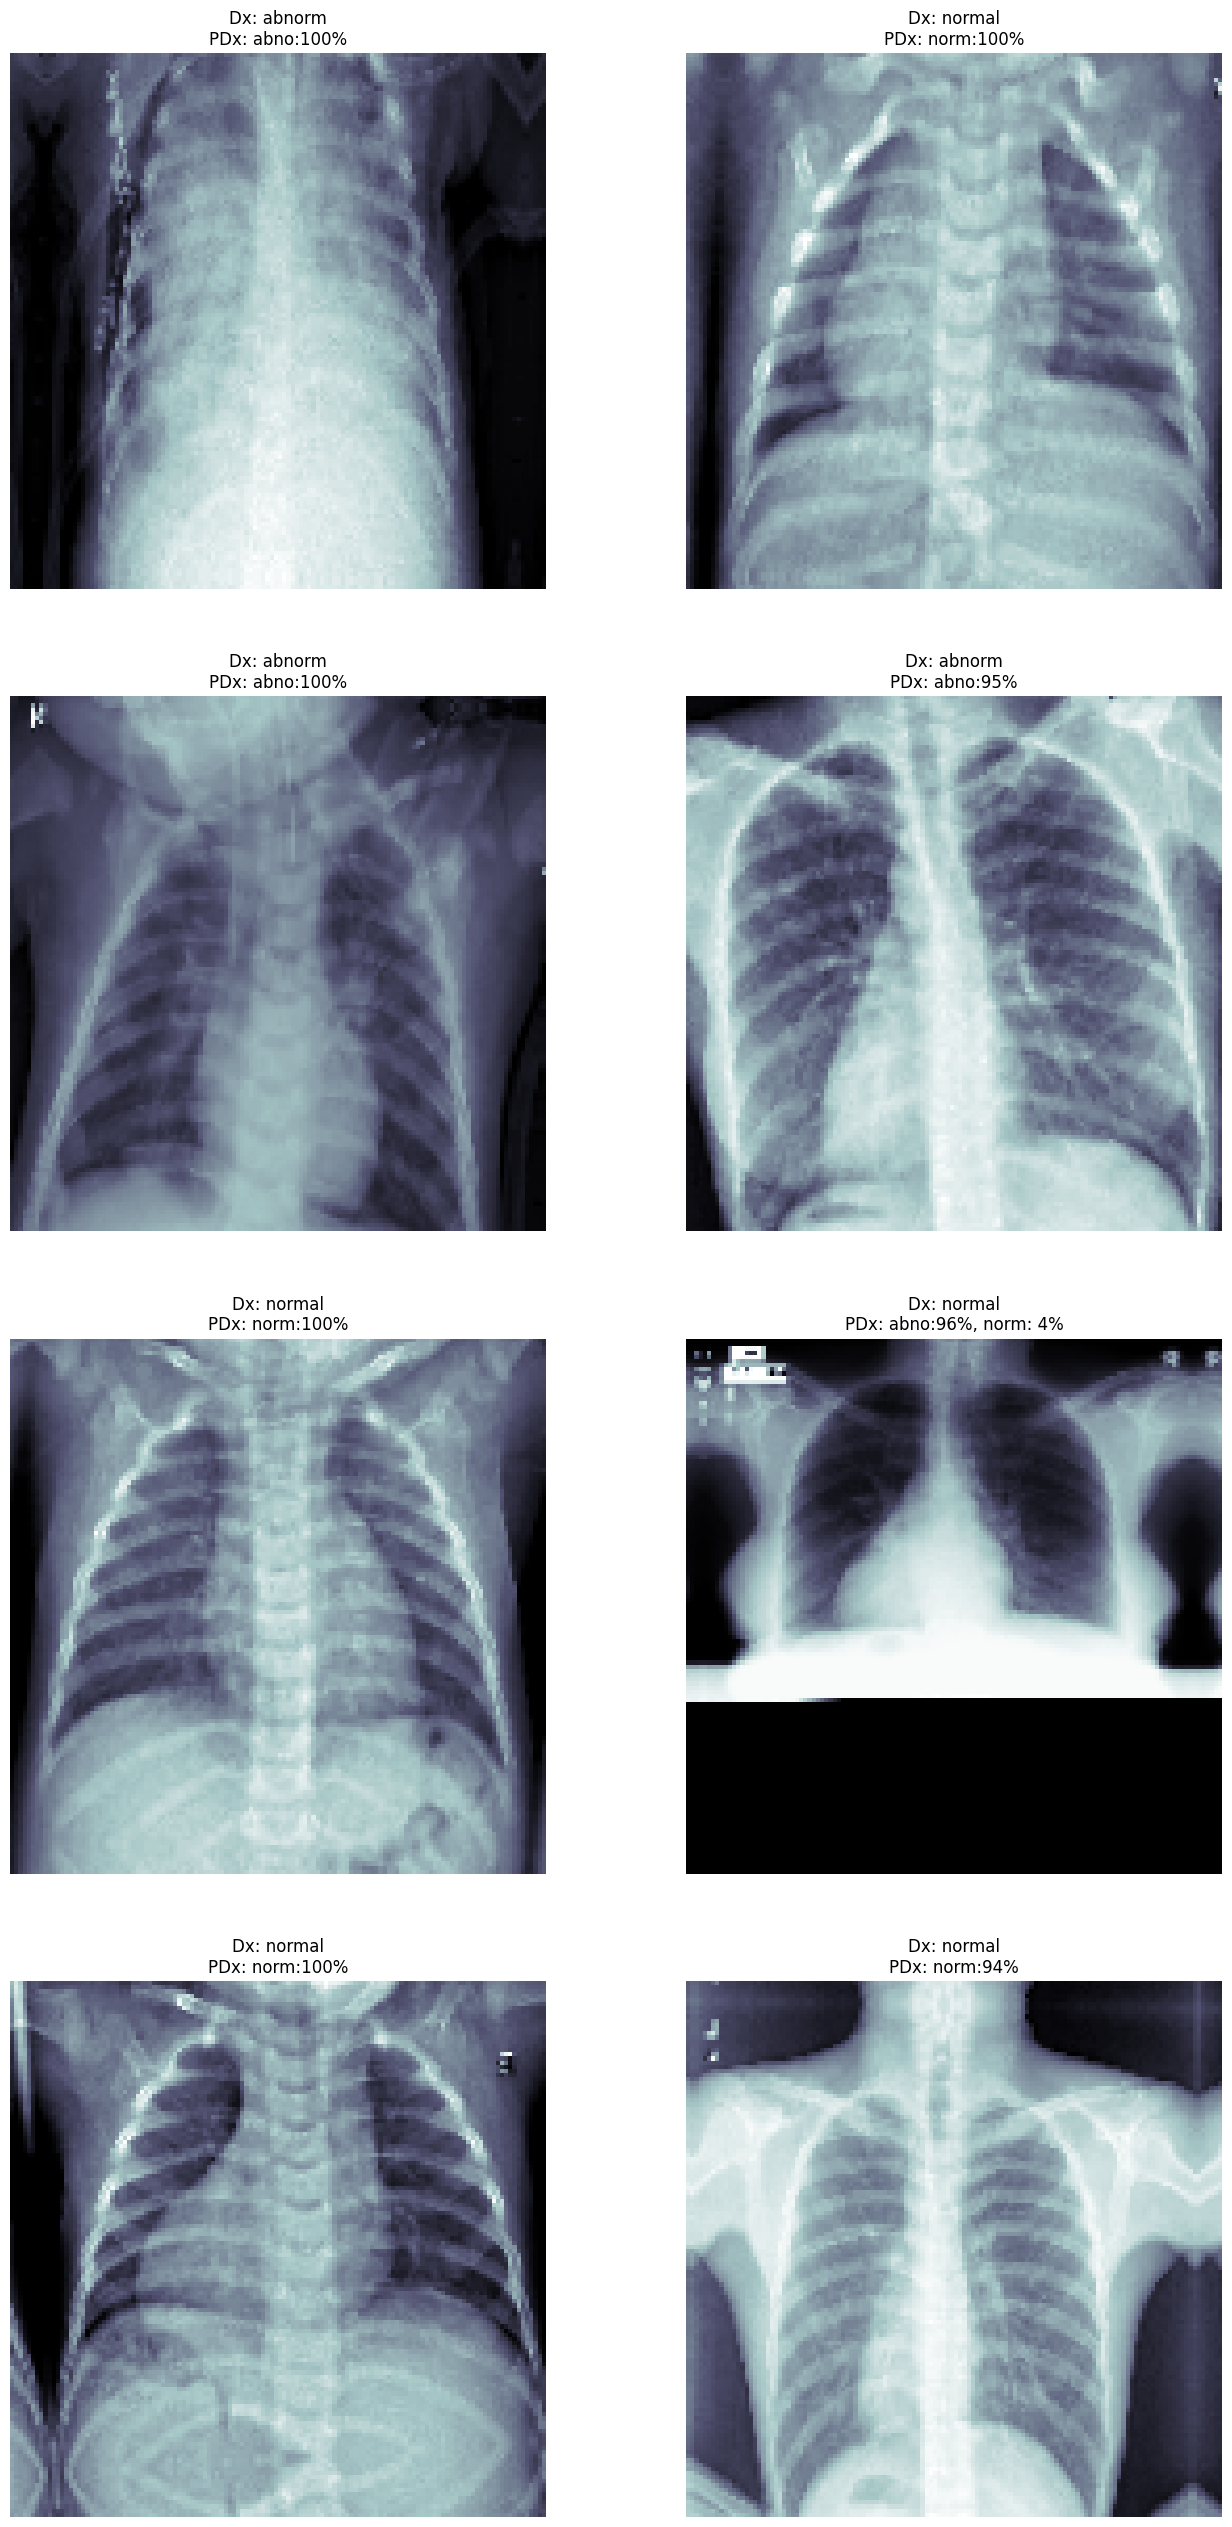

In [ ]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels,
                                                                  test_Y[idx])
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels,
                                                                  test_Y[idx], pred_Y[idx])
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')

In [ ]:
print('Normal CXR: ',valid_df[valid_df['findings']=='normal'].reset_index()['path'][0])
print('Abnormal CXR: ',valid_df[valid_df['findings']!='normal'].reset_index()['path'][0])

Normal CXR:  /content/chest_xray/train/NORMAL/IM-0445-0001.jpeg
Abnormal CXR:  /content/chest_xray/train/PNEUMONIA/person1375_virus_2366.jpeg


In [ ]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
  np_image = Image.open(filename)
  np_image = np.array(np_image).astype('float32')/255
  np_image = transform.resize(np_image, (128, 128, 3))
  np_image = np.expand_dims(np_image, axis=0)
  return np_image

image = load('/content/images/images/CHNCXR_0386_1.png')
img_pred=multi_disease_model.predict(image)

1/1 [==============================] - 0s 33ms/step


In [ ]:
for c_label, p_count in zip(all_labels,
                                     100*np.mean(img_pred,0)):
    print('%s: PDx: %2.2f%%' % (c_label, p_count))

# Expirimenting on Bone Supression

## Training BlackHat model on JSRT dataset

In [ ]:
from keras.models import Sequential
from keras.models import load_model
# Create a model with the same architecture
new_model = Sequential()
# ... Add layers to match the original model's architecture
base_model = load_model ('/content/final_model')
# Load the best weights
base_model.load_weights('/content/xray_class_weights.best.hdf5')  # Replace 'best_weights.h5' with the actual path to your saved weights file
#new_model.summary()

In [ ]:
from sklearn.model_selection import train_test_split
jsrt_train_df, jsrt_valid_df = train_test_split(jsrt_df,
                                   test_size = 0.25,
                                   random_state = 2018,
                                   stratify = jsrt_df['findings'])
print('train', jsrt_train_df.shape[0], 'validation', jsrt_valid_df.shape[0])

train 180 validation 61


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range= 0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

In [ ]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir,
                                     class_mode = 'categorical',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [ ]:
jsrt_train_gen = core_idg.flow_from_dataframe(dataframe=jsrt_train_df,
directory=None,
x_col = 'path',
y_col = 'findings',
class_mode = 'categorical',
classes = all_labels,
target_size = IMG_SIZE,
#color_mode = 'grayscale',
batch_size = 32)

jsrt_valid_gen = core_idg.flow_from_dataframe(dataframe=jsrt_valid_df,
directory=None,
x_col = 'path',
y_col = 'findings',
class_mode = 'categorical',
classes = all_labels,
target_size = IMG_SIZE,
#color_mode = 'grayscale',
batch_size = 16) # we can use much larger batches for evaluation

jsrt_test_X, jsrt_test_Y = next(core_idg.flow_from_dataframe(dataframe=jsrt_valid_df,
directory=None,
x_col = 'path',
y_col = 'findings',
class_mode = 'categorical',
classes = all_labels,
target_size = IMG_SIZE,
#color_mode = 'grayscale',
batch_size = 16))

Found 180 validated image filenames belonging to 2 classes.
Found 61 validated image filenames belonging to 2 classes.
Found 61 validated image filenames belonging to 2 classes.


In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
# weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=3)
callbacks_list = [checkpoint, early]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight("balanced", classes=np.unique(jsrt_train_gen.classes), y=jsrt_train_gen.classes)
cw = dict(zip( np.unique(jsrt_train_gen.classes), weights))
print(cw)

{0: 0.8108108108108109, 1: 1.3043478260869565}


In [ ]:
multi_disease_model.fit(train_gen,
                                  steps_per_epoch=5,
                                  validation_data = (jsrt_test_X, jsrt_test_Y),
                                  epochs = 16,
                                class_weight = cw,
                                  callbacks = callbacks_list)

Epoch 1/16
5/5 [==============================] - ETA: 0s - loss: 0.0349 - accuracy: 0.9875 - mae: 0.0236
Epoch 1: val_loss improved from inf to 1.94517, saving model to xray_class_weights.best.hdf5
5/5 [==============================] - 14s 3s/step - loss: 0.0349 - accuracy: 0.9875 - mae: 0.0236 - val_loss: 1.9452 - val_accuracy: 0.6875 - val_mae: 0.3116
Epoch 2/16
5/5 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9750 - mae: 0.0344
Epoch 2: val_loss did not improve from 1.94517
5/5 [==============================] - 14s 3s/step - loss: 0.0624 - accuracy: 0.9750 - mae: 0.0344 - val_loss: 2.3149 - val_accuracy: 0.6875 - val_mae: 0.3120
Epoch 3/16
5/5 [==============================] - ETA: 0s - loss: 0.0601 - accuracy: 0.9875 - mae: 0.0348
Epoch 3: val_loss did not improve from 1.94517
5/5 [==============================] - 13s 2s/step - loss: 0.0601 - accuracy: 0.9875 - mae: 0.0348 - val_loss: 2.5240 - val_accuracy: 0.6875 - val_mae: 0.3121
Epoch 4/16
5/5 [==

In [ ]:
jsrt_pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

32/32 [==============================] - 12s 364ms/step


In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(jsrt_test_Y[:,idx].astype(int), jsrt_pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')


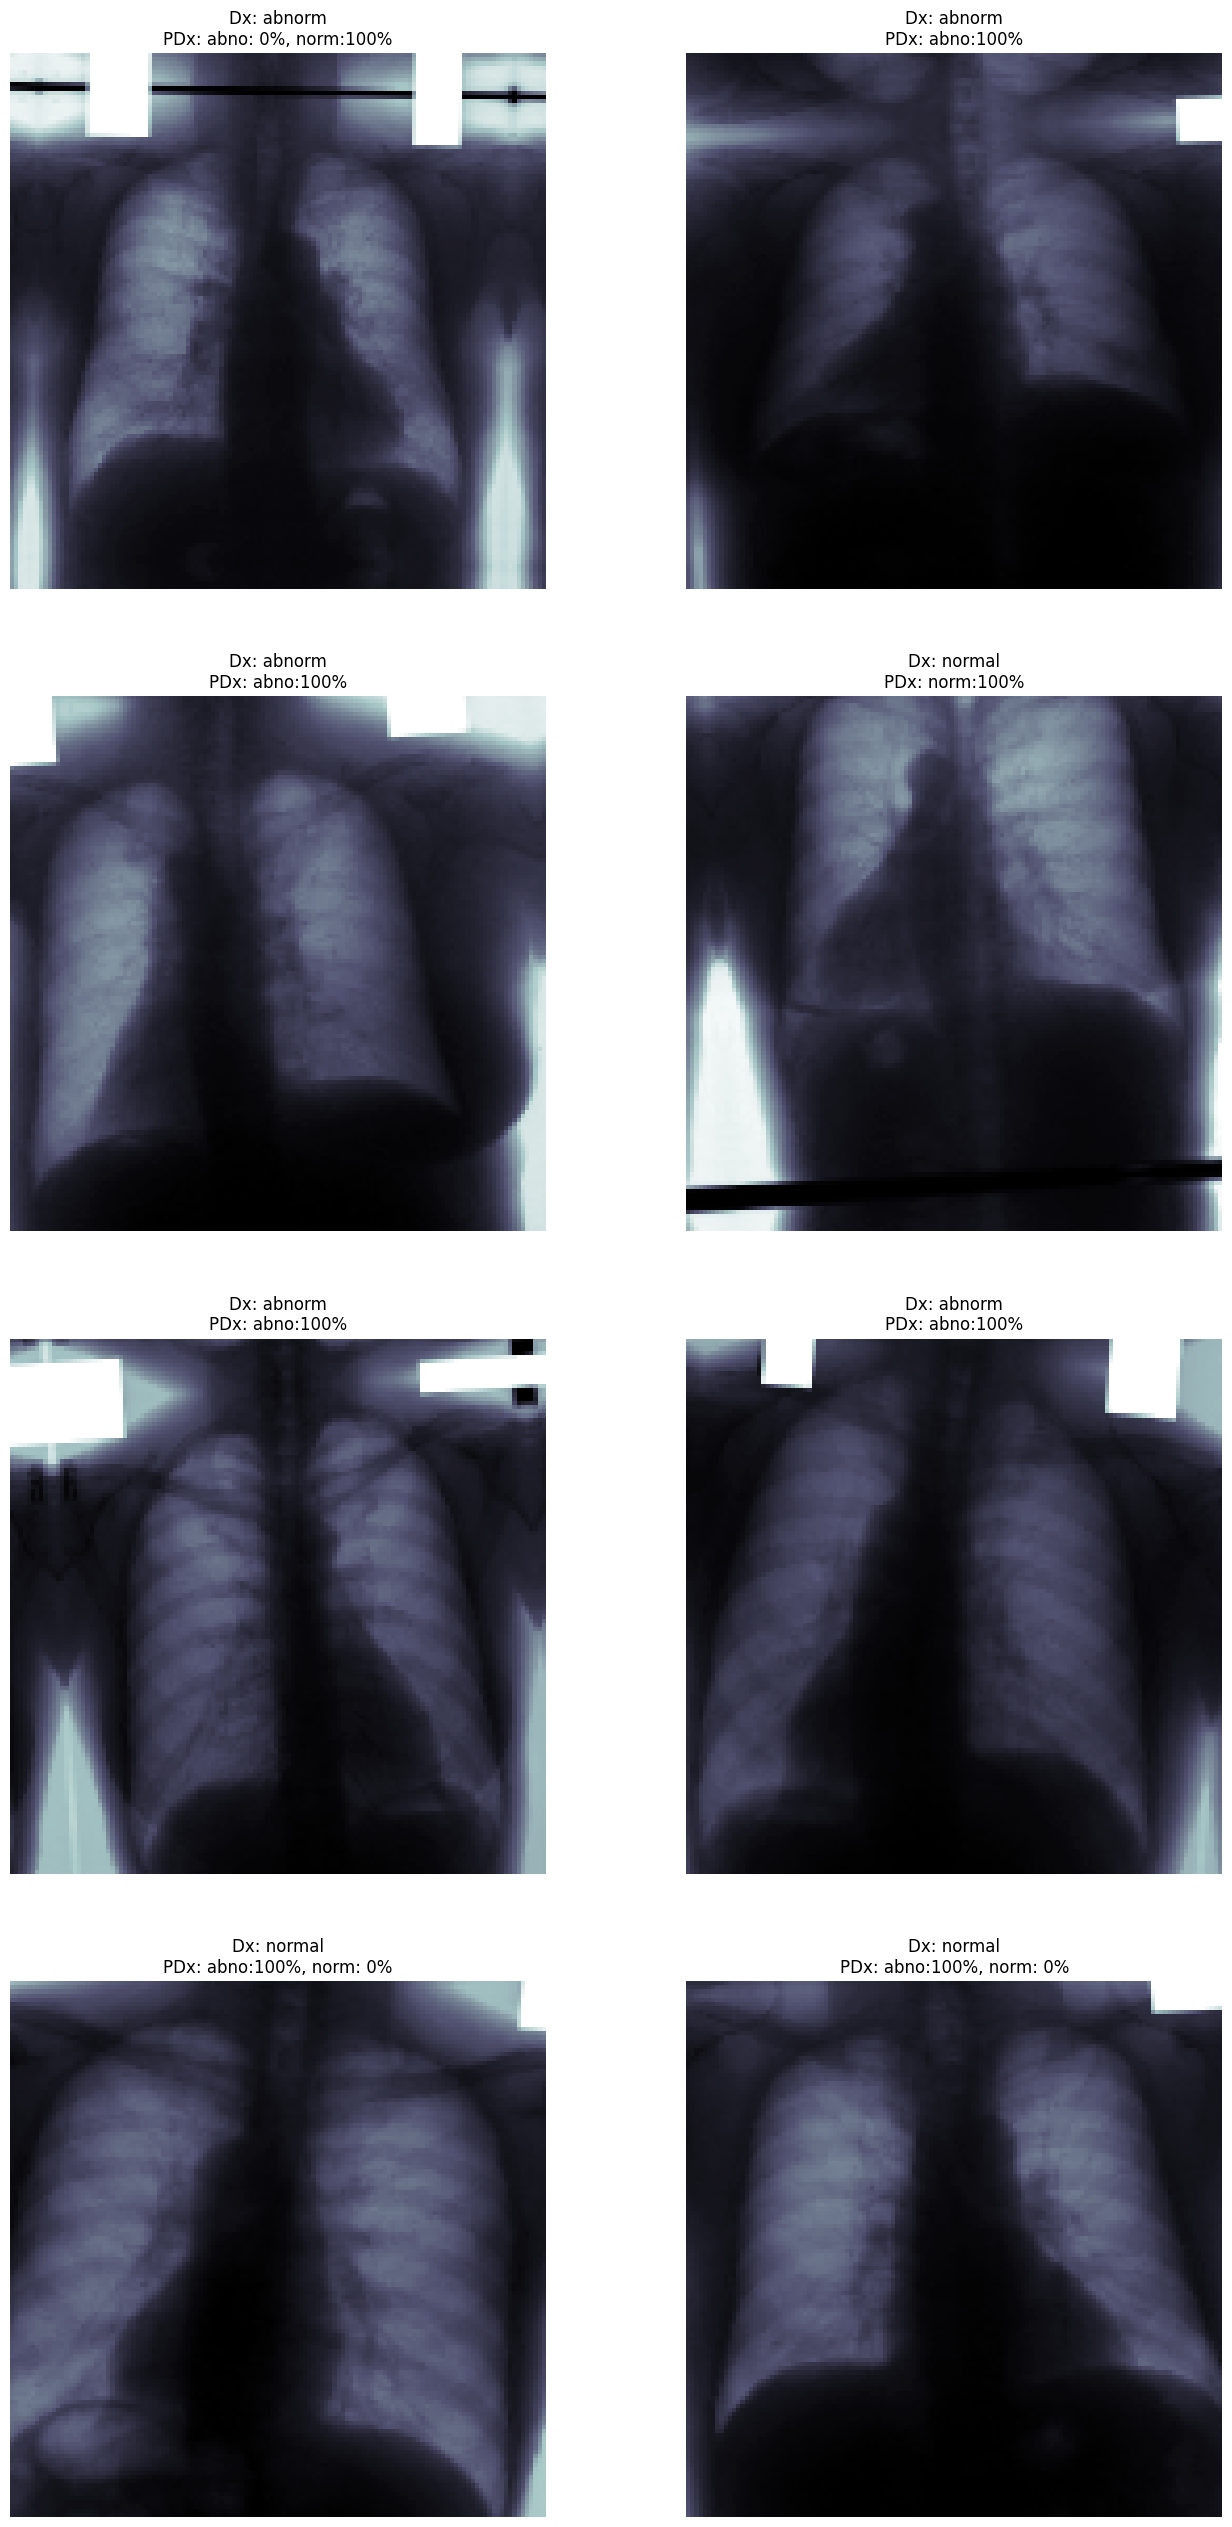

In [ ]:
sickest_idx = np.argsort(np.sum(jsrt_test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(jsrt_test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels,
                                                                  jsrt_test_Y[idx])
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels,
                                                                  jsrt_test_Y[idx], jsrt_pred_Y[idx])
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')